In [1]:
import matplotlib.pyplot as plt
import numpy as np
import time
import thermodynamics as td
from montecarlo import *
from energy import *

Some interesting ideas:

* Numerical method to find autocorrelation time? 
* See how the time taken increases for a 100*100 lattice. - time taken is 242 minutes or approximately 4 hours for a single temperature. Still this is too much. 
* Idea -*Can we, say, train a 'scale invariant machine learning model' , we train it on small lattices, and we can generate large lattice size* configurations easily from the trained decoder or something? This will make snapshot generation easier

Possible improvements:
* further improvements in space and time complexity in the following code?
* What kind of time requirements in saving the snapshots, optimal function to do so
* Improved estimators using clusters for estimating magnetisation etc. 

Other ideas:
* Can we create a gif/animation of the equilibriation process/ the markov chain? 

## Determination of autocorrelation time and equilibriation time

This is done for N=8

Let us do the following:
1. Take temperatures 1,2,3,4,5
2. For each temperature, perform the monte carlo for 1000 + 300 steps, 300 for equilibriation
3. Now, for each temperature, plot how the magnetisation changes in the monte carlo time
4. Verify that 300 indeed is a good number for equilibriation
5. Now, calculate the autocorrelation function for each temperature using the formula.
6. Plot the ACF for different temperatures
7. Now extract the autocorrelation time for each temperature

Once all of this is done, write this down into one single function/set of functions and repeat for N=[10,20,30,40,50]

See the following link: https://dfm.io/posts/autocorr/

### Important
Check if the code below is indeed correct. Why aren't we seeing critical slowing down? Check the following links:

https://physics.stackexchange.com/questions/626649/decorrelation-times-for-a-2d-ising-model-over-a-range-of-temperatures
https://physics.stackexchange.com/questions/445197/periodic-autocorrelation-function-for-ising-model?rq=1

See if your results match these. Keep doing it for 8*8 lattices till you are convinced

0. An important issue - negative or less than 1 or 2, or fractional AC times???
1. Key issue is that - we aren't seeing critical slowing in our plots. Ideally, the autocorrelation time must diverge near the critical point (peak in the case of finite lattices). But in our case instead of peaking it monotonically increased for increasing temperature. Check if this happens with the metropolis algorithm [resolved]

2. For better plots, use parallel chains at same temperature, calculate autocorrelation times for each, then average

3. There are two ways of calculating the AC time. One is the cumsum method you have used, the other is to fit a exponentially decaying curve of the form $e^{-t/\tau}$ to extract $\tau$

In [3]:
# Autocorrelation function #

def acf(data):
    ''' explain the logic of this code '''
    ''' Optimize this function '''
    x = np.array(data) 

    # Mean
    mean = np.mean(data)

    # Variance
    var = np.var(data)

    # Normalized data
    ndata = data - mean

    acorr = np.correlate(ndata, ndata, 'full')[len(ndata)-1:] 
    acorr = acorr / var / len(ndata)

    return acorr

def next_pow_two(n):
    i = 1
    while i < n:
        i = i << 1
    return i


def autocorr_func_1d(x, norm=True):
    x = np.atleast_1d(x)
    if len(x.shape) != 1:
        raise ValueError("invalid dimensions for 1D autocorrelation function")
    n = next_pow_two(len(x))

    # Compute the FFT and then (from that) the auto-correlation function
    f = np.fft.fft(x - np.mean(x), n=2 * n)
    acf = np.fft.ifft(f * np.conjugate(f))[: len(x)].real
    acf /= 4 * n

    # Optionally normalize
    if norm:
        acf /= acf[0]

    return acf

# For the following two functions, we use the link above.

def auto_window(taus, c):
    m = np.arange(len(taus)) < c * taus
    if np.any(m):
        return np.argmin(m)
    return len(taus) - 1

def autocorr_time(AC_f, c=5.0):
    taus = 2.0 * np.cumsum(AC_f) - 1.0
    window = auto_window(taus, c)
    return taus[window]

In [4]:
# Temperature array for actual simulation #

Temp = np.array(range(1,51))/10 # temperatures in steps of 0.1
Temp1 = np.array(range(200,300))/100 # more dense sampling of temperature around critical value
temp_AC = np.unique(np.append(Temp,Temp1)) # final temperature array

In [5]:
# Temperatures for running diagnostics and seeing correctness #

temp_AC = np.array([0.1,0.5,1,1.5,1.7,1.9,2.1,2.2,2.3,2.4,2.5,2.6,2.7,2.8,2.9,3,3.2,3.4,3.8,4,4.4,4.8,5])


iterations = 10000
t_eq = 300
T = iterations + t_eq
sizes = [10] # 8,16,32,64] # 64 takes too much time
# We use 5 for metropolis

mag = [] # monte carlo evolution of magnetisation for different temperatures
Mag = []
energy_MC = [] # monte carlo evolution of energy for different temperatures
ACF = []
tau = []
Tau = []
temp_mag = []
temp_ACF = []
cluster_size = [] 
Clusters_size_N = [] # For storing cluster sizes for all N
t=0

# Please try to understand the time scales relevant here in this code
# Also, how about a cluster size plot for this??
# How to speed up this calculation?

for size in sizes:
    for i in temp_AC:
        beta = 1/i
        lattice = 2*np.random.randint(0,2,(size,size))-1
        temp_mag = []
        temp_energy = []
        temp_cluster_size = []
        t = 0
        while t<T:
            lattice,clusters = Wolff(lattice,beta) #mcCycle(lattice,N=size,Temp=beta**(-1)) #
            temp_mag.append(td.magnetisation(lattice))
            temp_cluster_size.append(len(clusters))
            #temp_energy.append(hamilton(lattice, J=1))
            t += 1
        #energy_MC.append(temp_energy)
        #mag.append(temp_mag)
        temp_ACF = autocorr_func_1d(temp_mag)
        #ACF.append(temp_ACF)
        tau.append(autocorr_time(temp_ACF))
        cluster_size.append(np.mean(np.array(temp_cluster_size)))
    Tau.append(tau)
    tau = []
    #Mag.append(mag)
    #mag = []
    Clusters_size_N.append(cluster_size)
    cluster_size = []
    print("There, there, this won't take much time.")
    


There, there, this won't take much time.


In [ ]:
np.savetxt("AutoCorr_times.csv",Tau)
np.savetxt("Mags_MC_simulation.csv",Mag)

# Some Results of the above code

1. The plot below was obtained for a $5 \times 5$ lattice of spins with the algorithm for random update being the Metropolis algorithm. One can clearly see the critical slowing down problem in this case, with the autocorrelation time increasing abruptly near the finite size pseudo critical point, and then reducing exponentially. The monte carlo chain at each temperature was 100000 instances long.

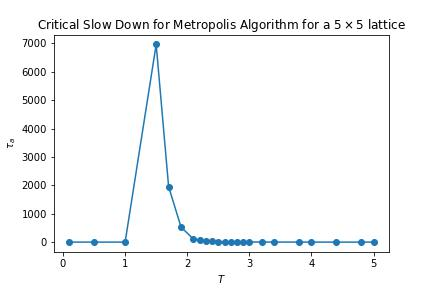

In [8]:
from IPython import display
display.Image("Metropolis_CSD.jpg")

### Question - what is the reason behind critical slowing down in metropolis algorithm?

1. For $T<T_c$, let us consider the monte carlo chain after equilibriation. That is, when most of the spins are ordered. Then, the probability of flipping a spin to the opposite direction to ordering is very low. Thus, the lattice does not change much /is not updated many times once it has equilibriated, and its magnetisation also saturates modulo some thermal fluctuations governed by the probabilistic boltzmann weights of transitions. On an average these fluctuations are uncorrelated, thus the autocorrelation time is minimal. 

    The key point here is as follows - when calculating the ACF, we subtract the mean from the time series. This essentially means that we are calculating the lagged correlation between the thermal fluctuations in the magnetisation on top of the true order parameter in the ordered state; and not the magnetisation itself. 

    Think of it in the following way - after a particular step A if some spins are flipped thermally, then after the step A+1, most of these spins will be flipped back to the ordered state, and new spins at different locations will be flipped to the opposite state *quite generally*, thus leading to a completely uncorrelated configuration with no causal link. - uncorrelated not in the sense that the two don't share the same magnetisation (which they indeed do!), but in the sense that the *fluctuations around the magnetisation are uncorrelated*. 

2. For $T>T_c$, the thermal fluctuations dominate over the tendency to order spins, and the order parameter - which is 0 now; and since these fluctuations are still uncorrelated between two different monte carlo steps, the autocorrelation time is again 0. 

    To rephrase it in another way, in $T>T_c$, the correlation length vanishes, and there are only small-sized clusters. This means that flipping some spins of an individual configuration completely alter these clusters, and the configuration, hence the magnetisation, is forgotten after each monte carlo step. 

3. For $T \sim T_c$ there is a correlation between the lagged magnetisations. How so? In this critical region, correlation length diverges, and clusters of various sizes form. It would be very hard for a single spin-flip based algorithm to clear out large clusters at once, thus, the cluster and hence the configurations persist over large ranges of the monte carlo time, thus, the high autocorrelation time. 

    To put it in another way, thermal spin flips of one step might cause cluster formation after the next step by hosting sites to form new, *possibly non-negligibly large* clusters. In this way, the fluctuations around the mean magnetisation become correlated.

Essentially, it all boils down to the divergence of the correlation length.

2. Note the cluster size plot obtained here. This is eerily similar to the magnetisation plot. This has two foremost implications for us. 

    Firstly, it means that at higher temperatures, each Wolff step requires less space and time to be computed. Now, the high cluster size issue at low temperatures is offset by the fact that it allows for faster sampling. Critical slowdown is also effectively minimized in this case as seen in the autocorrelation time plots, hence making this algorithm a much faster alternative to metropolis

    On the other hand, it is strikingly similar to the magnetisation plot. Infact, the magnetisation can be calculated from the cluster size that has been flipped. *Can you prove this point?* 

    This experiment was done for a lattice of $10 \times 10$ lattice spins, and the monte carlo run was for 10000 Wolff iterations after equilibriation

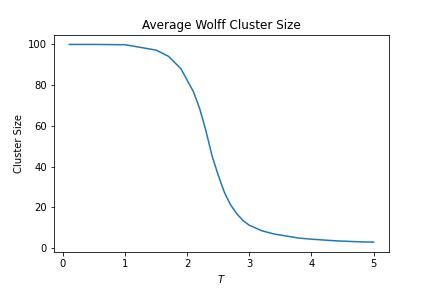

In [10]:
display.Image("ClusterSize.jpeg")